# A Mid-Infrared Analysis of Accreeting Supermassive Black Holes 
## Utilzing Diagnostic Tools to Identify Active Galactic Nuclei (AGN)
### Part 1: Mid-Infrared Color-Color Diagrams and Selecting AGN Candidates
Energy is released by AGN in the form of radiation, winds or plasma jets. This is known to have an impact on the sorrounding environment, subsequently this can affect the evolution of a galaxy in a number of ways. 

This script will involve applying a number of diagnostic tools to identify the pressence of an AGN in when detection is made in a survey.

This script makes use of multiwavelength data and applys the diagnostics to the ZFOURGE catalogue, specifically in the CDFS, COSMOS, and UDS fields.

In [43]:
# Begin by importing the required packages for the project
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os
#import astropy as ap
#import seaborn as sns

In [44]:
# Import the ZFOURGE Catalogue for each field, there should be a master catalogue for each field, importing all required information 


""" zfourge_fields = {'CDFS' : ['cdfs/cdfs.v1.6.11.cat', 'cdfs/cdfs.v1.6.9.zout', 'cdfs/cdfs.v1.6.9.sfr.v0.4.cat'], 'COSMOS' : ['cosmos//cosmos.v1.3.8.cat', 'cosmos/cosmos.v1.3.6.zout', 'cosmos\cosmos.v1.3.6.sfr.v0.4.cat'], 'UDS' : ['uds/uds.v1.5.10.cat', 'uds/uds.v1.5.8.zout', 'uds/uds.v1.5.8.sfr.v0.4.cat']}

field = 'COSMOS'



## by selecting field from the dictionary, we can then import the required files for the field
df = pd.DataFrame(np.genfromtxt(zfourge_fields[field][0], names=True, dtype=None, encoding='ascii')) # Master Catalogue, containg main info for file
eazy_df = pd.DataFrame(np.genfromtxt(zfourge_fields[field][1], names=True, dtype=None, encoding='ascii')) # EAZY Redshifts for the field
sfr_df = pd.DataFrame(np.genfromtxt(zfourge_fields[field][2], names=True, dtype=None, encoding='ascii')) # sfr fluxes for the field

 """
zfourge_fields = {
    'CDFS': ['cdfs/cdfs.v1.6.11.cat', 'cdfs/cdfs.v1.6.9.zout', 'cdfs/cdfs.v1.6.9.sfr.v0.4.cat'],
    'COSMOS': ['cosmos/cosmos.v1.3.8.cat', 'cosmos/cosmos.v1.3.6.zout', 'cosmos/cosmos.v1.3.6.sfr.v0.4.cat'],
    'UDS': ['uds/uds.v1.5.10.cat', 'uds/uds.v1.5.8.zout', 'uds/uds.v1.5.8.sfr.v0.4.cat']
}

field = 'COSMOS'

# Construct file paths using os.path.join() to make it platform-independent
catalog_file = os.path.join(zfourge_fields[field][0])
eazy_file = os.path.join(zfourge_fields[field][1])
sfr_file = os.path.join(zfourge_fields[field][2])

# Read the files into DataFrames
df = pd.DataFrame(np.genfromtxt(catalog_file, names=True, dtype=None, encoding='ascii'))
eazy_df = pd.DataFrame(np.genfromtxt(eazy_file, names=True, dtype=None, encoding='ascii'))
sfr_df = pd.DataFrame(np.genfromtxt(sfr_file, names=True, dtype=None, encoding='ascii'))

In [45]:
# Threshold for error 
sigma = 5

# adding required information into the master dataframe based on id
df = pd.merge(df, eazy_df[['id', 'z_peak']], on='id')
# Add 24um fluxes to dataframe from her_df based on id column
df = pd.merge(df, sfr_df[['id', 'f24', 'e24']], on='id')

# As 24um fluxes are in mJy convert to microJy
df['f24'] = df['f24']*1000
df['e24'] = df['e24']*1000


# Create a column to store if the selection diagnostic chooses the object as an AGN
df["Messias Selection"] = 0
df["Lacy Selection"] = 0
# This will be the main dataset, which will be broken up into two datasets for each metric, the final result will be then put back into this



## The Lacy Wedge
The code below aims to select a subset of the dataset that corresponds to known agn, this is defined within the selection criteria in the literature (Lacy et al. 2004, 2007; Sajina et al. 2012).

The criteria are as follows:

$log_{10}(f_{5.8}/f_{3.6}) > -0.1$ 

$log_{10}(f_{8.0}/f_{4.5}) > -0.2$

$log_{10}(f_{8.0}/f_{4.5}) < 0.8 \times log_{10}(f_{5.8}/f_{3.6}) + 0.5$


In [46]:
# We now need to create a new dataframe which will contain the information for the selection diagnostics, this will be used to determine which objects are AGN's
# reduce dataframe to where there are values of flux that are greater than 0

# filter out all zero values for the fluxes and only use galaxies where the use flag is 1
lacy_df = df[(df['f_IRAC_36'] > 0) & ((df['f_IRAC_45'] > 0)) & (df['f_IRAC_58'] > 0) & (df['f_IRAC_80'] > 0) & (df['use'] == 1)].copy()

# extra filtering based on the errors of the fluxes 20% of flux, as is done by Lacy et al. 2004.  
#lacy_error_threshold = 0.2
#lacy_df = lacy_df[(lacy_df['e_IRAC_36'] < (lacy_error_threshold * lacy_df['f_IRAC_36'])) & (lacy_df['e_IRAC_45'] < (lacy_error_threshold * lacy_df['f_IRAC_45'])) & (lacy_df['e_IRAC_58'] < (lacy_error_threshold * lacy_df['f_IRAC_58'])) & (lacy_df['e_IRAC_80'] < (lacy_error_threshold * lacy_df['f_IRAC_80']))]


# Use flux/error thresholds to filter out bad sources
lacy_df = lacy_df[(lacy_df['f_IRAC_36'] >= sigma * lacy_df['e_IRAC_36']) & ( lacy_df['f_IRAC_45'] >= sigma * lacy_df['e_IRAC_45']) & ( lacy_df['f_IRAC_58'] >= sigma * lacy_df['e_IRAC_58']) & ( lacy_df['f_IRAC_80'] >= sigma * lacy_df['e_IRAC_80'])]





In [47]:
# Implementing the selection condition outlined by Lacy et al. 2004, 2007, and Sajina et al. 2005
lacy_selection_condition = (np.log10(lacy_df['f_IRAC_58'] / lacy_df['f_IRAC_36']) > -0.1) & (np.log10(lacy_df['f_IRAC_80'] / lacy_df['f_IRAC_45']) > -0.2) & (np.log10(lacy_df['f_IRAC_80'] / lacy_df['f_IRAC_45']) < 0.8 * np.log10(lacy_df['f_IRAC_58'] / lacy_df['f_IRAC_36']) + 0.5)

# lacy selection condition will return a boolean array of indicies where the condition has or has not been met, we can then use this to select the objects that meet the condition
# we can filter the dataset to where this is true
lacy_df_selected = lacy_df[lacy_selection_condition == True]
lacy_df_rejected = lacy_df[lacy_selection_condition == False]


len(lacy_df_selected)

241

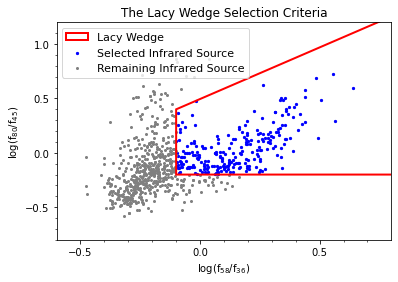

In [48]:
# Plotting the Selection

# Create scatter plot for selected data
plt.scatter(np.log10(lacy_df_selected['f_IRAC_58'] / lacy_df_selected['f_IRAC_36']), np.log10(lacy_df_selected['f_IRAC_80'] / lacy_df_selected['f_IRAC_45']), c='blue', marker='o',s=5 ,label='Selected Infrared Source')

# Create scatter plot for remaining data
plt.scatter(np.log10(lacy_df_rejected['f_IRAC_58'] / lacy_df_rejected['f_IRAC_36']), np.log10(lacy_df_rejected['f_IRAC_80'] / lacy_df_rejected['f_IRAC_45']), c='grey', marker='o',s=4 ,label='Remaining Infrared Source')

# Define vertices for AGN wedge - This doesn't quite work. I need to figure out how to plot the wedge.
wedge_vertices = [
  (np.log10(lacy_df_selected['f_IRAC_58'] / lacy_df_selected['f_IRAC_36']).max() + 0.4, -0.2),
  (-0.1, -0.2),
  (-0.1, 0.4), 
  (np.log10(lacy_df_selected['f_IRAC_58'] / lacy_df_selected['f_IRAC_36']).max()+ 2, 3)
]

# Create a polygon patch for the AGN wedge
wedge_polygon = plt.Polygon(wedge_vertices, closed=True, edgecolor='r', facecolor='none', linestyle='-', linewidth=2, label='Lacy Wedge')

# Add the AGN wedge polygon patch to the plot
plt.gca().add_patch(wedge_polygon)

# Add labels and title
plt.xlabel('log(f$_{58}$/f$_{36}$)')
plt.ylabel('log(f$_{80}$/f$_{45}$)')
plt.title('The Lacy Wedge Selection Criteria')

# Set the limits
plt.xlim([-0.6, 0.8])
plt.ylim([-0.8, 1.2])

# Set the ticks
plt.xticks([-0.5, 0, 0.5])
plt.yticks([-0.5, 0, 0.5, 1.0])
plt.minorticks_on()


# Finally add the legend
plt.legend(loc='upper left', fontsize=11)


In [49]:
# Adjust the Lacy Selection Criteria Accordingly in the main dataframe
df.loc[lacy_df_selected.index, 'Lacy Selection'] = 1 # Set selected sources to 1 using boolean array selection 

## Error Analysis for the Lacy Wedge and Donley Wedge
now that we have seen that we have a working script that can analyze and select points in the lacy wedge, we need to make sure that are including the errors that are in the dataset. As we can filter our fata based on the specific sigma value specified, we can use this to show what data is present. Altering the dataset as needed for each run.

The idea is to extend this at a later time, and to have this code flexible enough that it will output everything specified in 1 run.

For the lacy wedge we need to see how error is propogated. We use the general error propagation formulation shown below, for a function of two variables that are both independent of each other.

\begin{align*}
\Delta f = \sqrt{\left(\left|\frac{\partial f}{\partial a}\right|\cdot \Delta a\right)^2\ + \left(\left|\frac{\partial f}{\partial b}\right|\cdot \Delta b\right)^2}
\end{align*}

Applying this to the lacy wedge. We see from abvoe the lacy wedge has an x axis: $x = log_{10}(f_{5.8}/f_{3.6})$ and a y axis: $y = log_{10}(f_{8.0}/f_{4.5})$. From this we can see that we need to propagate the error from the fluxes, using the general equation above. Applying the error to the scatter plot, and then generalising it to not have too much mess on the plot. We see the error propogated below.

The error for the x axis, and y axis is:

for x
\begin{align*}
\Delta x &= \sqrt{\left(\left|\frac{\partial x}{\partial f_{5.8}}\right|\cdot \Delta f_{5.8}\right)^2 \ + \left(\left|\frac{\partial x}{\partial f_{3.6}}\right|\cdot \Delta f_{3.6}\right)^2}\\
& = \sqrt{\left(\left|\frac{\partial}{\partial f_{5.8}}\left(log_{10}(f_{5.8}) -log_{10}(f_{3.6})\right)\right|\cdot \Delta f_{5.8}\right)^2 + \left(\left|\frac{\partial}{\partial f_{3.6}}\left(log_{10}(f_{5.8})-log_{10}(f_{3.6})\right)\right|\cdot \Delta f_{3.6}\right)^2}\\
& = \sqrt{\left(\frac{1}{f_{5.8}ln(10)}\cdot \Delta f_{5.8}\right)^2 + \left(\frac{1}{f_{3.6}ln(10)}\cdot \Delta f_{3.6}\right)^2}\\
& = \sqrt{\left(\frac{\Delta f_{5.8}}{f_{5.8}ln(10)}\right)^2 + \left(\frac{\Delta f_{3.6}}{f_{3.6}ln(10)}\right)^2}\\
& = \frac{1}{ln(10)}\sqrt{\left(\frac{\Delta f_{5.8}}{f_{5.8}}\right)^2 + \left(\frac{\Delta f_{3.6}}{f_{3.6}}\right)^2} 
\end{align*}

for y
\begin{align*}
\Delta y &= \sqrt{\left(\left|\frac{\partial y}{\partial f_{8.0}}\right|\cdot \Delta f_{8.0}\right)^2 \ + \left(\left|\frac{\partial y}{\partial f_{4.5}}\right|\cdot \Delta f_{4.5}\right)^2}\\
& = \sqrt{\left(\left|\frac{\partial}{\partial f_{8.0}}\left(log_{10}(f_{8.0}) -log_{10}(f_{4.5})\right)\right|\cdot \Delta f_{8.0}\right)^2 + \left(\left|\frac{\partial}{\partial f_{4.5}}\left(log_{10}(f_{8.0})-log_{10}(f_{4.5})\right)\right|\cdot \Delta f_{4.5}\right)^2}\\
& = \sqrt{\left(\frac{1}{f_{8.0}ln(10)}\cdot \Delta f_{8.0}\right)^2 + \left(\frac{1}{f_{4.5}ln(10)}\cdot \Delta f_{4.5}\right)^2}\\
& = \sqrt{\left(\frac{\Delta f_{8.0}}{f_{8.0}ln(10)}\right)^2 + \left(\frac{\Delta f_{4.5}}{f_{4.5}ln(10)}\right)^2}\\
& = \frac{1}{ln(10)}\sqrt{\left(\frac{\Delta f_{8.0}}{f_{8.0}}\right)^2 + \left(\frac{\Delta f_{4.5}}{f_{4.5}}\right)^2}
\end{align*}



In [68]:
# Create a function that can implement this error
def lacy_donley_uncertainity(a, error_a, b, error_b):
    total_uncertainity = (1/(np.log(10)) * np.sqrt((error_a/a)**2 + (error_b/b)**2))
    return total_uncertainity

# create new columns in the dataframe for the uncertainity in each axis for the lacy and donley plots

# x-axis error
df['e_log_58_36'] = lacy_donley_uncertainity(df['f_IRAC_58'], df['e_IRAC_58'], df['f_IRAC_36'], df['e_IRAC_36'])
# y-axis error
df['e_log_80_45'] = lacy_donley_uncertainity(df['f_IRAC_80'], df['e_IRAC_80'], df['f_IRAC_45'], df['e_IRAC_45'])




## Donley Selection Criteria
The Donley selection (Donley et al. 2012) is a revised irac selection which is based on both the lacy selection (Lacy et al. 2004, 2007) and the stern selection (Stern et al. 2005). Donley aims to select a subset of the dataset that corresponds to known agn. The donley selection in particular was designed to ignore as many star forming contaminants as possible. Donley works on the same xy axis as Lacy, but produces a more fine tuned result. The selection criteria is as follows:


\begin{align*}
x &= \log_{10}\left(\frac{f_{5.8\mu m}}{f_{3.6\mu m}}\right) , y= \log_{10}\left(\frac{f_{8.0\mu m}}{f_{4.5\mu m}}\right) \\
\land x &\geq 0.08 \land y \geq 0.15 \\
\land y &\geq (1.21 \cdot x) - 0.27 \land y \leq (1.21 \cdot x) + 0.27 \\
\land f_{4.5\mu m} &> f_{3.6\mu m} \land f_{5.8\mu m} > f_{4.5\mu m} \land f_{8.0\mu m} > f_{5.8\mu m}
\end{align*}


In [51]:

# Create a new dataframe that will contain the information for the selection diagnostics, this will be used to determine which objects are AGN's for the Donley criteria.
donley_df = df[(df['f_IRAC_36'] > 0) & ((df['f_IRAC_45'] > 0)) & (df['f_IRAC_58'] > 0) & (df['f_IRAC_80'] > 0) & (df['use'] == 1)].copy()

# Use flux/error thresholds to filter out bad sources
donley_df = donley_df[(donley_df['f_IRAC_36'] >= sigma * donley_df['e_IRAC_36']) & (donley_df['f_IRAC_45'] >= sigma * donley_df['e_IRAC_45']) & (donley_df['f_IRAC_58'] >= sigma * donley_df['e_IRAC_58']) & (donley_df['f_IRAC_80'] >= sigma * donley_df['e_IRAC_80'])]



In [52]:
# Implementing the selection condition outlined by Lacy et al. 2004, 2007, and Sajina et al. 2005
# for readibility this will be broken up into three selection criteria

#x = np.log(donley_df['f_IRAC_58']/donley_df['f_IRAC_36'])
#y= np.log(donley_df['f_IRAC_80']/donley_df['f_IRAC_45'])

donley_selection_condition_1 = ((np.log(donley_df['f_IRAC_58']/donley_df['f_IRAC_36']) >= 0.08) & (np.log(donley_df['f_IRAC_80']/donley_df['f_IRAC_45']) >= 0.15))
donley_selection_condition_2 = ((np.log(donley_df['f_IRAC_80']/donley_df['f_IRAC_45']) >= (1.21 * np.log(donley_df['f_IRAC_80']/donley_df['f_IRAC_45'])) - 0.27) & (np.log(donley_df['f_IRAC_80']/donley_df['f_IRAC_45']) <= (1.21 * np.log(donley_df['f_IRAC_80']/donley_df['f_IRAC_45'])) + 0.27))
donley_selection_condition_3 = (donley_df['f_IRAC_45'] > donley_df['f_IRAC_36']) & (donley_df['f_IRAC_58'] > donley_df['f_IRAC_45']) & (donley_df['f_IRAC_80'] > donley_df['f_IRAC_58'])
donley_selection_condition = donley_selection_condition_1 & donley_selection_condition_2 & donley_selection_condition_3

# lacy selection condition will return a boolean array of indicies where the condition has or has not been met, we can then use this to select the objects that meet the condition
# we can filter the dataset to where this is true
donley_df_selected = donley_df[donley_selection_condition_1 == True]
donley_df_rejected = donley_df[donley_selection_condition_1 == False]


len(donley_df_selected)

80

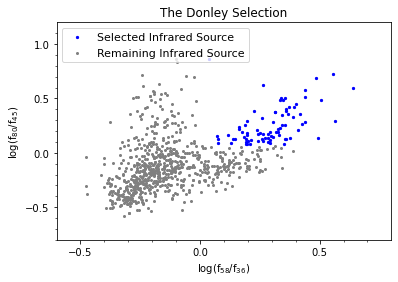

In [53]:
# Create scatter plot for selected data
plt.scatter(np.log10(donley_df_selected['f_IRAC_58'] / donley_df_selected['f_IRAC_36']), np.log10(donley_df_selected['f_IRAC_80'] / donley_df_selected['f_IRAC_45']), c='blue', marker='o',s=5 ,label='Selected Infrared Source')

# Create scatter plot for remaining data
plt.scatter(np.log10(donley_df_rejected['f_IRAC_58'] / donley_df_rejected['f_IRAC_36']), np.log10(donley_df_rejected['f_IRAC_80'] / donley_df_rejected['f_IRAC_45']), c='grey', marker='o',s=4 ,label='Remaining Infrared Source')

# Set the title and axis labels
plt.xlabel('log(f$_{58}$/f$_{36}$)')
plt.ylabel('log(f$_{80}$/f$_{45}$)')
plt.title('The Donley Selection')

# Set the limits
plt.xlim([-0.6, 0.8])
plt.ylim([-0.8, 1.2])

# Set the ticks
plt.xticks([-0.5, 0, 0.5])
plt.yticks([-0.5, 0, 0.5, 1.0])
plt.minorticks_on()


# Finally add the legend
plt.legend(loc='upper left', fontsize=11)

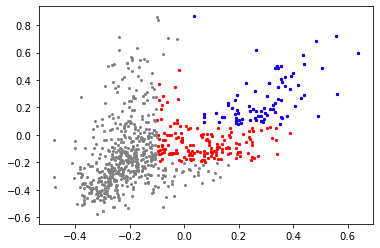

In [54]:
# For completeness we also show the Lacy Wedge on the same plot, with the donley selection
plt.scatter(np.log10(lacy_df_selected['f_IRAC_58'] / lacy_df_selected['f_IRAC_36']), np.log10(lacy_df_selected['f_IRAC_80'] / lacy_df_selected['f_IRAC_45']), c='red', marker='o',s=5 ,label='Lacy Selected Infrared Source')
plt.scatter(np.log10(lacy_df_rejected['f_IRAC_58'] / lacy_df_rejected['f_IRAC_36']), np.log10(lacy_df_rejected['f_IRAC_80'] / lacy_df_rejected['f_IRAC_45']), c='grey', marker='o',s=4 ,label='Lacy Remaining Infrared Source')
plt.scatter(np.log10(donley_df_selected['f_IRAC_58'] / donley_df_selected['f_IRAC_36']), np.log10(donley_df_selected['f_IRAC_80'] / donley_df_selected['f_IRAC_45']), c='blue', marker='o',s=5 ,label='Donley Selected Infrared Source')
#plt.scatter(np.log10(donley_df_rejected['f_IRAC_58'] / donley_df_rejected['f_IRAC_36']), np.log10(donley_df_rejected['f_IRAC_80'] / donley_df_rejected['f_IRAC_45']), c='grey', marker='o',s=4 ,label='Donley Remaining Infrared Source')

In [55]:
# Updating the original dataframe with the selection by donley
df.loc[donley_df_selected.index, 'Donley Selection'] = 1 # Set selected sources to 1 using boolean array selection

## Now we will use the modified dataset and using a different selection criteria we will aim to select a subset of the dataset that corresponds to known agn. For this case we will use the Messias KI and KIM Selection ("Messias et al. 2012, 2013") 
as ZFOURGE only deals with redshifts below 4 we will only make use of redshifts below 4 and above 0.
this selection criteria deals with AB magnitudes instead of rest frame fluxes and is shown below.

This selection criteria behaves differently depending on we are considering a redshift below 1.8 or above 1.8
Noting that the selection criteria was taken from the paper by Messias et al. 2012

KI Selection Criteria:
$z<1.8\begin{cases}K_{s}-[4.5]>0&\\ [4.5]-[8.0]>0&\end{cases} \\$

KIM Selection Criteria:
$z>1.8\begin{cases}[8.0]-[24]>-2.9\times ([4.5]-[8.0])+2.8&\\ [8.0]-[24]>0.5&\end{cases}$
 
as we are considering AB magnitudes we will need to convert the fluxes to magnitudes, this is done using the following formula:

$AB_f = 25 - 2.5 log_{10}(f)$

where f is the flux in microjansky


In [56]:
# As the Messias KIM selection reqires the conversion of observed fluxes into AB magnitudes we can define a function to convert the fluxes into magnitudes
def flux_to_AB(flux):
    ab_f = 25 - 2.5*np.log10(flux)
    return ab_f

In [57]:
# We are dealing with two seperate redshift rangers z < 1.8 and z > 1.8
messias_df = df[(df['f_IRAC_36'] > 0) & (df['f_IRAC_45'] > 0) & (df['f_IRAC_58'] > 0) & (df['f_IRAC_80'] > 0) & (df['use'] == 1) & (df['f24'] > 0) & (df['f_Ks'] > 0)].copy()

# We filter the messias data based on criteria defined in Messias et al. 2012, 2013. Here they only consider fluxes with a error of less than a third of the measured flux.
# KsIRAC_messias_error_threshold = 0.33
# MIPS_messias_error_threshold = 0.33


#messias_df = messias_df[(messias_df['e_IRAC_36'] < (KsIRAC_messias_error_threshold * messias_df['f_IRAC_36'])) & (messias_df['e_IRAC_45'] < (KsIRAC_messias_error_threshold * messias_df['f_IRAC_45'])) & (messias_df['e_IRAC_58'] < (KsIRAC_messias_error_threshold * messias_df['f_IRAC_58'])) & (messias_df['e_IRAC_80'] < (KsIRAC_messias_error_threshold * messias_df['f_IRAC_80'])) & (messias_df['e_Ks'] < (KsIRAC_messias_error_threshold * messias_df['f_Ks']))]
#messias_df = messias_df[(messias_df['e24'] < (MIPS_messias_error_threshold * messias_df['f24']))]


messias_df = messias_df[(messias_df['f_IRAC_36'] >= sigma * messias_df['e_IRAC_36']) & ( messias_df['f_IRAC_45'] >= sigma * messias_df['e_IRAC_45']) & ( messias_df['f_IRAC_58'] >= sigma * messias_df['e_IRAC_58']) & ( messias_df['f_IRAC_80'] >= sigma * messias_df['e_IRAC_80']) & ( messias_df['f_Ks'] >= sigma * messias_df['e_Ks']) & ( messias_df['f24'] >= sigma * messias_df['e24'])]


# Create new columns that deal with the flux in AB magnitudes
messias_df['f_IRAC_45_AB'] = messias_df['f_IRAC_45'].apply(flux_to_AB)
messias_df['f_IRAC_80_AB'] = messias_df['f_IRAC_80'].apply(flux_to_AB)
messias_df['f24_AB'] = messias_df['f24'].apply(flux_to_AB)
messias_df['f_Ks_AB'] = messias_df['f_Ks'].apply(flux_to_AB)

# May have to do more filtering on accepting correct values for the magnitudes

In [58]:
# First we will deal with the case where z < 1.8
# Create a boolean array to select the correct redshift range
# Create two sub dataframes for the two redshift ranges
messias_lower_df = messias_df[(messias_df['z_peak'] < 1.8) & (messias_df['z_peak'] > 0.2)] 
messias_upper_df = messias_df[(messias_df['z_peak'] > 1.8) & (messias_df['z_peak'] < 3.2)]

### The KI Selection 
$z<1.8\begin{cases}K_{s}-[4.5]>0&\\ [4.5]-[8.0]>0&\end{cases} \\$

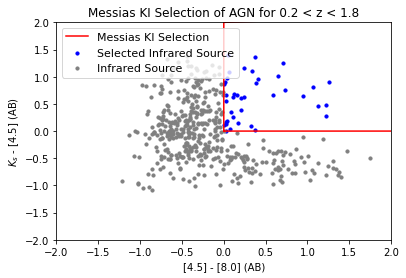

In [59]:
# First dealing with the redshift in the lower reigon
# We will need to define a selection criteria that will be able
# to select the correct objects 
lower_messias_selection_condition = (messias_lower_df['f_IRAC_45_AB'] - messias_lower_df['f_IRAC_80_AB'] > 0) & (messias_lower_df['f_Ks_AB'] - messias_lower_df['f_IRAC_45_AB'] > 0)

# lower messias selection condition will return a boolean array of indicies where the condition has or has not been met, we can then use this to select the objects that meet the condition
# we can filter the dataset to where this is true
messias_lower_df_selected = messias_lower_df[lower_messias_selection_condition== True]
messias_lower_df_rejected = messias_lower_df[lower_messias_selection_condition== False]

# Now attempt to plot the selected sources in blue and the remaining sources in grey
plt.scatter(messias_lower_df_selected['f_IRAC_45_AB'] - messias_lower_df_selected['f_IRAC_80_AB'], messias_lower_df_selected['f_Ks_AB'] - messias_lower_df_selected['f_IRAC_45_AB'], s=10, color='blue', label='Selected Infrared Source')
plt.scatter(messias_lower_df_rejected['f_IRAC_45_AB'] - messias_lower_df_rejected['f_IRAC_80_AB'], messias_lower_df_rejected['f_Ks_AB'] - messias_lower_df_rejected['f_IRAC_45_AB'], s=10, color='grey', label='Infrared Source')
plt.title("Messias KI Selection of AGN for 0.2 < z < 1.8")
plt.xlabel("[4.5] - [8.0] (AB)")
plt.ylabel("$K_s$ - [4.5] (AB)")


# Changes the limits to something more appropriate
plt.xlim([-2, 2])
plt.ylim([-2, 2])

# Plot the selection line corresponding to the selection criteria
plt.plot([0, 0,2, 2.1, 0],[0,2, 2.1, 0, 0], 'r-', label='Messias KI Selection') 

# Finally add the legend
plt.legend(loc='upper left', fontsize=11)

In [60]:
# We now update the main dataframe based on the selection criteria returning true
df.loc[messias_lower_df_selected.index, 'Messias Selection'] = 1 

### The KIM Selection 
$z>1.8\begin{cases}[8.0]-[24]>-2.9\times ([4.5]-[8.0])+2.8&\\ [8.0]-[24]>0.5&\end{cases}$

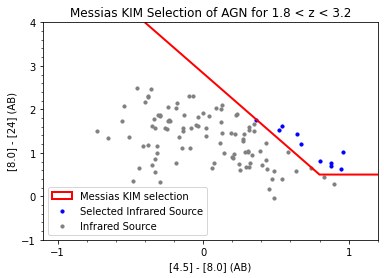

In [61]:
# Create a selection criteria to filter the upper redshift value dataset
kim_selection_condition_a = (messias_upper_df['f_IRAC_80_AB'] - messias_upper_df['f24_AB'] > ((-2.9 * (messias_upper_df['f_IRAC_45_AB'] - messias_upper_df['f_IRAC_80_AB'])) + 2.8))
kim_selection_condition_b = ((messias_upper_df['f_IRAC_80_AB'] - messias_upper_df['f24_AB']) > 0.5)
upper_messias_selection_condition = (kim_selection_condition_a & kim_selection_condition_b)

# lower messias selection condition will return a boolean array of indicies where the condition has or has not been met, we can then use this to select the objects that meet the condition
# we can filter the dataset to where this is true
messias_upper_df_selected = messias_upper_df[upper_messias_selection_condition== True]
messias_upper_df_rejected = messias_upper_df[upper_messias_selection_condition== False]

# plot the selected sources in blue, and the remaining sources in grey
plt.scatter(messias_upper_df_selected['f_IRAC_45_AB'] - messias_upper_df_selected['f_IRAC_80_AB'],messias_upper_df_selected['f_IRAC_80_AB'] - messias_upper_df_selected['f24_AB'], s=10, color='blue', label='Selected Infrared Source')
plt.scatter(messias_upper_df_rejected['f_IRAC_45_AB'] - messias_upper_df_rejected['f_IRAC_80_AB'],messias_upper_df_rejected['f_IRAC_80_AB'] - messias_upper_df_rejected['f24_AB'], s=10, color='grey', label='Infrared Source')

plt.title("Messias KIM Selection of AGN for 1.8 < z < 3.2")
plt.xlabel("[4.5] - [8.0] (AB)")
plt.ylabel("[8.0] - [24] (AB)")

# We can adjust these limits later
plt.xlim([-1.1, 1.2])
plt.ylim([-0.2, 4])
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1, 2, 3, 4])
plt.minorticks_on()

# Mathematically redefine this latter rather than doing from inspection
wedge_vertices = [
    (1.5, 0.5),
    (0.8,0.5),
    (-0.40,4)
]

# Create a polygon patch for the AGN wedge
wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor='none', linestyle='-', linewidth=2, label='Messias KIM selection')

# Add the AGN wedge polygon patch to the plot
plt.gca().add_patch(wedge_polygon)

# Finally add the legend
plt.legend(loc='lower left')
plt.show()



In [62]:
# We now update the main dataframe based on the selection criteria returning true
df.loc[messias_upper_df_selected.index, 'Messias Selection'] = 1 

## Output the results of the selection into a CSV file.
Now that both selection criteria have been applied, we can check the selection criteria, and look for values that are true for both selection criteria, this will give us a subset of the dataset that corresponds to known AGN. Alternatively we can look for values that are true for either selection criteria, this will give us a subset of the dataset that corresponds to known AGN in each method. 


In [63]:
num_lacy_selections = len(df[df['Lacy Selection'] == 1])
num_donley_selections = len(df[df['Donley Selection'] == 1])
num_messias_selections = len(df[df['Messias Selection'] == 1])
num_all_selections = len(df[(df['Lacy Selection'] == 1) | (df['Messias Selection'] == 1) | (df['Donley Selection'] == 1)])

# Print out the number of each selections 
print("Number of Lacy Selections: ", num_lacy_selections)
print("Number of Donley Selections: ", num_donley_selections)
print("Number of Messias Selections: ", num_messias_selections)
print("Number of Unique Selections: ", num_all_selections)

Number of Lacy Selections:  241
Number of Donley Selections:  80
Number of Messias Selections:  50
Number of Unique Selections:  254


In [64]:
# Create the folder if it doesn't exist
folder_path = 'diagnostic selections'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)




# Output the a csv file containing the identifying information (id) for each of the selected sources
# There will be three csv outputs, one for each selection criteria, and one for the combined selection criteria
def export_AGN_data(field, all_data, selection_criteria, sigma):
    
    if all_data == True:
        file_name =  field+'_full_data_'+str(sigma)+'_sigma.csv'
        file_path = os.path.join(folder_path, file_name)
        df.to_csv(file_path, index=False)
    else:
        if selection_criteria == 'Lacy':
            file_name = field+'_lacy_selection_'+str(sigma)+'_sigma.csv'
            file_path = os.path.join(folder_path, file_name)
            df[df['Lacy Selection'] == 1].to_csv(file_path, index=False)
        elif selection_criteria == 'Messias':
            file_name = field+'_messias_selection_'+str(sigma)+'_sigma.csv'
            file_path = os.path.join(folder_path, file_name)
            df[df['Messias Selection'] == 1].to_csv(file_path, index=False)
        elif selection_criteria == 'Donley':
            file_name = field+'_donley_selection_'+str(sigma)+'_sigma.csv'
            file_path = os.path.join(folder_path, file_name)
            df[df['Donley Selection'] == 1].to_csv(file_path, index=False)
        elif selection_criteria == 'Combined':
            file_name = field+'_combined_selection_'+str(sigma)+'_sigma.csv'
            file_path = os.path.join(folder_path, file_name)
            df[(df['Messias Selection'] == 1) | (df['Lacy Selection'] == 1) | (df['Donley Selection'])].to_csv(file_path, index=False)

# export AGN data based on 
export_AGN_data(field, False,'Combined', sigma)  